### ML acidoCEST
- Code source: [link](https://scikit-learn.org/0.15/auto_examples/plot_digits_pipe.html)
- Modified by Julio Cardenas-Rodriguez, Ph.D.
- CAMEL West @Tucson, AZ
- License: TBD

Change Log  
- 2018_05_30: Initial Version

### To -do list
- [ ] load uncentered data
- [ ] find importance of each frequency
- [ ] pipeline to PCA ( if needed)
- [ ] Feature selection

In [1]:
molecules = ['Polymer',
             ' Monomer 2 (M2)',
             'Monomer 1 (M1)',
             'Iopamidol',
             'Gadolinium in 20mM Iopamidol']
n = 0

In [2]:
### Libraries
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
%matplotlib inline

In [3]:
data_file ='../data/raw/CEST-ML-format_mdp_20181121_230pm_JCR_CJK_20190415.xlsx'


df         = pd.read_excel(data_file, sheetname= molecules[n])

In [9]:
info = df[['Sample ID', 'pH', 'concentration_mM','temperature_C', 'sat time_sec','sat power_uT']]
pH = info['pH'].copy()
print('Info shape \n',info.shape)
print('--'*10)
X = df.select_dtypes(include=['float64']).drop(['pH', 'concentration_mM',     'sat power_uT'],axis = 1)
print('X shape \n', X.shape )
print('--'*10)
for C in info.columns:  
    print(info[C].nunique(), C + ' unique values')
    print('--'*10)

Info shape 
 (465, 6)
--------------------
X shape 
 (465, 261)
--------------------
1 Sample ID unique values
--------------------
15 pH unique values
--------------------
11 concentration_mM unique values
--------------------
7 temperature_C unique values
--------------------
7 sat time_sec unique values
--------------------
7 sat power_uT unique values
--------------------


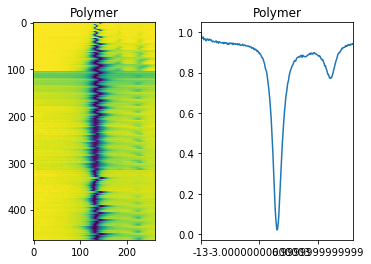

In [10]:
plt.subplot(1,2,1)
plt.imshow(X); plt.title(molecules[n]);
plt.subplot(1,2,2);plt.title(molecules[n]);
X.iloc[205,:].plot()

#### Logistic Regression

In [11]:
### define function to train model based on cuttoff for pH
def train_logistic_PCA_pipeline(Spectra, pH_observed, min_n=2, max_n= 10, pH_cut_off = 7.0, n_cs=20):
    # cut off > pH
    y = 1*(pH_observed > pH_cut_off)
    # X data
    X = Spectra.copy()
        
    # Logistic
    logistic = linear_model.LogisticRegression(solver='liblinear', penalty='l1',max_iter=500,random_state=42)

    #PCA
    pca = PCA(random_state=42)
    
    # pipeline
    pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
    
    # Training parameters
    num_pca_components = np.arange(min_n,max_n,1)
    Cs = np.logspace(-3, 2, n_cs)
    
    param_grid ={
    'pca__n_components': num_pca_components,
    'logistic__C': Cs,
    'logistic__class_weight': ['balanced',None]
    }
    
    
    estimator = GridSearchCV(pipe, param_grid, verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
    
    #AUC
    y_probas = estimator.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_probas)
    
    #Confusion
    skplt.metrics.plot_confusion_matrix(y_test, estimator.predict(X_test), normalize=True)
    plt.show()
    
    return estimator.best_estimator_, X_train, X_test, y_train, y_test

In [12]:
### define function to train model based on cuttoff for pH
def train_logistic_regression(Spectra, pH_observed, pH_cut_off = 7.0, n_cs=20):
    # cut off > pH
    y = 1*(pH_observed > pH_cut_off)
    # X data
    X = Spectra.copy()
        
    # Logistic
    logistic = linear_model.LogisticRegression(solver='liblinear', penalty='l1',max_iter=500,random_state=42)

    # Training parameters
    Cs = np.logspace(-3, 2, n_cs)
    
    param_grid ={
    'C': np.logspace(-4, 4, n_cs),
    'class_weight': ['balanced',None]
    }
    
    
    estimator = GridSearchCV(logistic, param_grid, verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
    
    #AUC
    y_probas = estimator.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_probas)
    
    #Confusion
    skplt.metrics.plot_confusion_matrix(y_test, estimator.predict(X_test), normalize=True)
    plt.show()
    
    return estimator.best_estimator_, X_train, X_test, y_train, y_test

    # Grid Search on Pipeline
    estimator = GridSearchCV(logistic,
                         dict(
                              C= Cs,
                              class_weight= ['balanced',None],
                              fit_intercept= [True,False]), 
                             verbose = 1, cv = 3, n_jobs=3, iid = True)

Note on metrics
- precision = positive predictive value
- recall    = sensitivity

###  -training pH >7.0  

In [13]:
(pH> 7).value_counts(normalize = True).round(2)

False    0.53
True     0.47
Name: pH, dtype: float64

### Pipeline

In [14]:
s = X.shape[1]
step_size = 5

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 395 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 960 out of 960 | elapsed:    5.4s finished


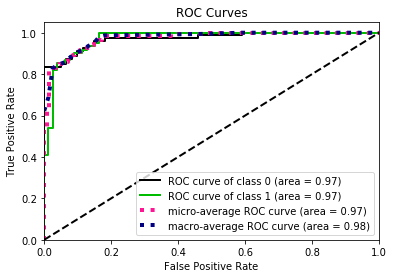

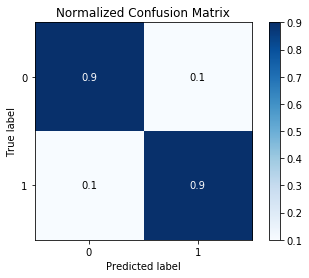

In [15]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_PCA_pipeline( X.iloc[:,0:s:step_size], pH,
                                                                           min_n=2, max_n= 10,
                                                                           pH_cut_off = 7.0, n_cs=20 )

### Only Logistic Regression

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:  3.1min finished


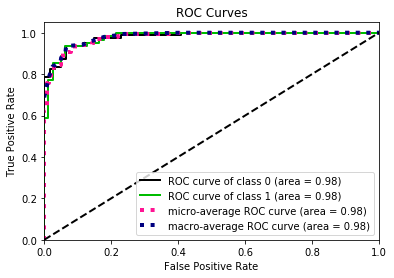

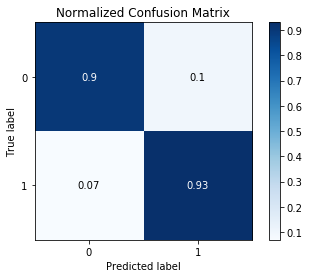

In [16]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_regression( X.iloc[:,0:s:step_size], pH,
                                                                           pH_cut_off = 7.0, n_cs=20 )

### pH > 6.8

In [17]:
(pH > 6.8).value_counts(normalize = True).round(2)

True     0.6
False    0.4
Name: pH, dtype: float64

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  83 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done 683 tasks      | elapsed:   13.1s
[Parallel(n_jobs=3)]: Done 955 out of 960 | elapsed:   16.0s remaining:    0.1s
[Parallel(n_jobs=3)]: Done 960 out of 960 | elapsed:   16.0s finished


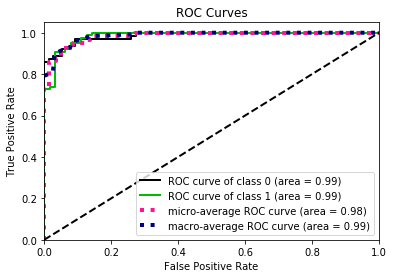

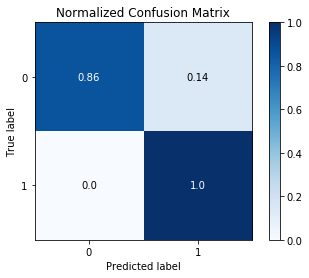

In [18]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_PCA_pipeline( X.iloc[:,0:s:1], pH,
                                                                           min_n=2, max_n= 10,
                                                                           pH_cut_off = 6.8, n_cs=20 )